In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
#import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/Users/drcaptainray/tempevn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/Users/drcaptainray/tempevn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# Any results you write to the current directory are saved as output.

In [3]:
train = pd.read_csv('tmdb-box-office-prediction/train.csv')
test = pd.read_csv('tmdb-box-office-prediction/test.csv')


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [5]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [6]:
train.shape

(3000, 23)

In [7]:
# Delete the redundant column which does not add any inormation
train.drop(columns=['homepage', 'imdb_id', 'original_title', 'poster_path'],axis = 1 ,inplace=True)

test.drop(columns=['homepage', 'imdb_id', 'original_title', 'poster_path'],axis = 1 ,inplace=True)

In [8]:
# number of null values in the data

train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
original_language           0
overview                    8
popularity                  0
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [9]:
# to plot the null values in the different columns
null_values = train.isna().sum().reset_index()


x = null_values.iloc[:,0]
y = null_values.iloc[:,1]

x = x.tolist()
y = y.tolist()

<BarContainer object of 19 artists>

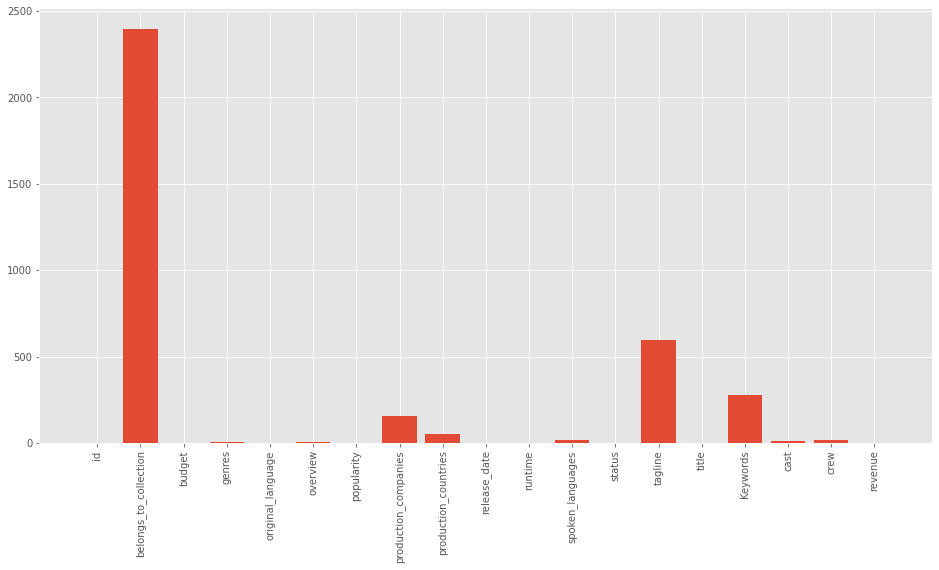

In [10]:
plt.figure(figsize=(16, 8))
plt.xticks(rotation='vertical')
plt.bar(x, y ,label='Null values count')

In [11]:
# https://www.kaggle.com/gravix/gradient-in-a-box

dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)


In [12]:
# shape of train and test data set
train.shape, test.shape

((3000, 19), (4398, 18))

In [13]:
# To find if the film belongs to any big collection
# to do
# normalize


train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)


# Data processing for the Genre columns

In [14]:
#from typing import Iterable 
from collections import Iterable


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x
            

In [15]:
            
Top_genre = Counter(list(flatten(list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)))).most_common(10)

All_genre = Counter(list(flatten(list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values))))

# to convert the tuple into the dict
dict_top_genre = dict(All_genre)

Total_genres_count = sum(Counter(list(flatten(list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)))).values())

print(Top_genre)

[('Drama', 1531), ('Comedy', 1028), ('Thriller', 789), ('Action', 741), ('Romance', 571), ('Crime', 469), ('Adventure', 439), ('Horror', 301), ('Science Fiction', 290), ('Family', 260)]


In [16]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

# max and sum
train['max_genres_norm'] = train['all_genres'].apply(lambda x: max([dict_top_genre[i]/Total_genres_count for i in x.split(',')]) if x != '' else 0)

## create a column based on top genre movies

test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

# max and sum
test['max_genres_norm'] = test['all_genres'].apply(lambda x: max([dict_top_genre[i]/Total_genres_count for i in x.split(',')]) if x != '' else 0)


train = train.drop(['genres','all_genres'], axis=1)
test = test.drop(['genres','all_genres'], axis=1)

# Production Companies

#### production compnaies plays a important role for the movie.. often top rated production companies tend to earn good revenue. so parsing the column product companies to get more details from it.

In [17]:
Top_production_companies = Counter(list(flatten(list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)))).most_common(30)
print(Top_production_companies)

All_production_companies = Counter(list(flatten(list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values))))

# to convert the tuple into the dict
dict_top_production_companies = dict(Top_production_companies)

Top_production_companies_count = sum(dict_top_production_companies.values())
print('Total count of the production companies',Top_production_companies_count)


[('Warner Bros.', 202), ('Universal Pictures', 188), ('Paramount Pictures', 161), ('Twentieth Century Fox Film Corporation', 138), ('Columbia Pictures', 91), ('Metro-Goldwyn-Mayer (MGM)', 84), ('New Line Cinema', 75), ('Touchstone Pictures', 63), ('Walt Disney Pictures', 62), ('Columbia Pictures Corporation', 61), ('TriStar Pictures', 53), ('Relativity Media', 48), ('Canal+', 46), ('United Artists', 44), ('Miramax Films', 40), ('Village Roadshow Pictures', 36), ('Regency Enterprises', 31), ('BBC Films', 30), ('Dune Entertainment', 30), ('Working Title Films', 30), ('Fox Searchlight Pictures', 29), ('StudioCanal', 28), ('Lionsgate', 28), ('DreamWorks SKG', 27), ('Fox 2000 Pictures', 25), ('Summit Entertainment', 24), ('Hollywood Pictures', 24), ('Orion Pictures', 24), ('Amblin Entertainment', 23), ('Dimension Films', 23)]
Total count of the production companies 1768


In [18]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

train['max_production_companies_norm'] = train['all_production_companies'].apply(lambda x: max([dict_top_production_companies[i]/Top_production_companies_count if i in dict_top_production_companies.keys() else 0 for i in x.split(',')]) if x != '' else 0)


# for production in Top_production_companies:
#     train['production_company_' + production[0]] = train['all_production_companies'].apply(lambda x: 1 if production[0] in x else 0)

test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

test['max_production_companies_norm'] = test['all_production_companies'].apply(lambda x: max([dict_top_production_companies[i]/Top_production_companies_count if i in dict_top_production_companies.keys() else 0 for i in x.split(',')]) if x != '' else 0)


# for production in Top_production_companies:
#     test['production_company_' + production[0]] = test['all_production_companies'].apply(lambda x: 1 if production[0] in x else 0)



train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

# Production Countries

In [19]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['iso_3166_1'] for i in x] if x != {} else []).values)
Top_countries = Counter([i for j in list_of_countries for i in j]).most_common(30)


# to convert the tuple into the dict
dict_top_production_countries = dict(Top_countries)

Top_production_countries_count = sum(dict_top_production_countries.values())
print('Total movie count of the production country',Top_production_countries_count)

Total movie count of the production country 3872


In [20]:
train['num_production_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_countries'] = train['production_countries'].apply(lambda x: ','.join(sorted([i['iso_3166_1'] for i in x])) if x != {} else '')


train['max_production_country_norm'] = train['all_production_countries'].apply(lambda x: max([dict_top_production_countries[i]/Top_production_countries_count if i in dict_top_production_countries.keys() else 0 for i in x.split(',')]) if x != '' else 0)

# for country in Top_countries:
#     train['production_country_' + country[0]] = train['all_countries'].apply(lambda x: 1 if country[0] in x else 0)

test['num_production_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_countries'] = test['production_countries'].apply(lambda x: ','.join(sorted([i['iso_3166_1'] for i in x])) if x != {} else '')


test['max_production_country_norm'] = test['all_production_countries'].apply(lambda x: max([dict_top_production_countries[i]/Top_production_countries_count if i in dict_top_production_countries.keys() else 0 for i in x.split(',')]) if x != '' else 0)



# # for country in Top_countries:
#     test['production_country_' + country[0]] = test['all_countries'].apply(lambda x: 1 if country[0] in x else 0)
    
train = train.drop(['num_production_countries', 'all_production_countries'], axis=1)
test = test.drop(['num_production_countries', 'all_production_countries'], axis=1)

# Spoken language

In [21]:
## feature engineering part has to take care production country and spoken language

In [22]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_language = Counter([i for j in list_of_languages for i in j]).most_common(5)

dict_top_language = dict(top_language)

Top_languages_count = sum(dict_top_language.values())
print('Total movie count of the production country',Top_languages_count)

Total movie count of the production country 3466


In [23]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

train['max_language_norm'] = train['all_languages'].apply(lambda x: max([dict_top_language[i]/Top_languages_count if i in dict_top_language.keys() else 0 for i in x.split(',')]) if x != '' else 0)


# train['max_language_norm'] = train['all_languages'].apply(lambda x: max([dict_top_language[i]/Top_languages_count for i in x.split(',')]) if x != '' else 0)

# top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
# for g in top_languages:
#     train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
# test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
# test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
# for g in top_languages:
#     test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

# train = train.drop(['spoken_languages', 'all_languages'], axis=1)
# test = test.drop(['spoken_languages', 'all_languages'], axis=1)

In [24]:
#cast_name

In [25]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_cast_names = Counter([i for j in list_of_cast_names for i in j]).most_common(500)

dict_cast_names = dict(top_cast_names)

Top_cast_names_count = sum(dict_cast_names.values())
print('Total movie count acted wrt cast names',Top_cast_names_count)

Total movie count acted wrt cast names 6188


In [26]:
dict_cast_names

{'Samuel L. Jackson': 30,
 'Robert De Niro': 30,
 'Morgan Freeman': 27,
 'J.K. Simmons': 25,
 'Bruce Willis': 25,
 'Liam Neeson': 25,
 'Susan Sarandon': 25,
 'Bruce McGill': 24,
 'John Turturro': 24,
 'Forest Whitaker': 23,
 'Willem Dafoe': 23,
 'Bill Murray': 22,
 'Owen Wilson': 22,
 'Nicolas Cage': 22,
 'Sylvester Stallone': 21,
 'Jason Statham': 21,
 'Keith David': 21,
 'John Goodman': 21,
 'Mel Gibson': 21,
 'Sigourney Weaver': 21,
 'Frank Welker': 20,
 'Michael Caine': 20,
 'George Clooney': 20,
 'Denzel Washington': 20,
 'Robert Duvall': 20,
 'Ed Harris': 20,
 'Dennis Quaid': 20,
 'Richard Jenkins': 20,
 'Matt Damon': 20,
 'Christopher Plummer': 19,
 'Gene Hackman': 19,
 'Christopher Walken': 19,
 'William H. Macy': 19,
 'James Franco': 19,
 'Jim Broadbent': 19,
 'John C. Reilly': 19,
 'Kevin Bacon': 19,
 'Christian Bale': 19,
 'Alec Baldwin': 19,
 'Allison Janney': 18,
 'Brian Cox': 18,
 'John Leguizamo': 18,
 'Julianne Moore': 18,
 'Robert Downey Jr.': 18,
 'Michael Shannon': 1

In [27]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

train['max_cast_norm'] = train['all_cast'].apply(lambda x: max([dict_cast_names[i]/Top_cast_names_count if i in dict_cast_names.keys() else 0 for i in x.split(',')]) if x != '' else 0)



# Cast Gender

In [28]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j])

Counter({2: 27949, 1: 13533, 0: 20329})

In [29]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)

train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))


test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)

test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

# train = train.drop(['cast'], axis=1)
# test = test.drop(['cast'], axis=1)

In [30]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108)]

In [31]:
# top director 

list_directors_name = list(train['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Director' ] if x != {} else []).values)
dict_director_names = dict(Counter([i for j in list_directors_name for i in j]))

Top_director_names_count = sum(dict_director_names.values())

In [32]:
# top producer


list_producer_name = list(train['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Producer' ] if x != {} else []).values)
dict_producer_names = dict(Counter([i for j in list_producer_name for i in j]))

Top_producer_names_count = sum(dict_producer_names.values())

In [33]:
# top Original Music Composer


list_music_composer_name = list(train['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Original Music Composer' ] if x != {} else []).values)
dict_composer_names = dict(Counter([i for j in list_music_composer_name for i in j]).most_common(15))

Top_composer_names_count = sum(dict_composer_names.values())

In [34]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)

train['crew_director'] = train['crew'].apply(lambda x: ','.join(sorted([i['name'] for i in x if i['job'] == 'Director'])) if x != {} else '')
train['crew_director_norm'] = train['crew_director'].apply(lambda x: [(dict_director_names[i]/Top_director_names_count) if i in dict_director_names.keys() else 0 for i in x.split(',')][0] if x != '' else 0)
train['crew_director_log_norm'] = train['crew_director'].apply(lambda x: [np.log(dict_director_names[i])+1 if i in dict_director_names.keys() else 1 for i in x.split(',')][0] if x != '' else 0)

train['crew_producer'] = train['crew'].apply(lambda x: ','.join(sorted([i['name'] for i in x if i['job'] == 'Producer'])) if x != {} else '')
train['crew_producer_norm'] = train['crew_producer'].apply(lambda x: [(dict_producer_names[i]/Top_producer_names_count) if i in dict_producer_names.keys() else 0 for i in x.split(',')][0] if x != '' else 0)
train['crew_producer_log_norm'] = train['crew_producer'].apply(lambda x: [np.log(dict_producer_names[i])+1 if i in dict_producer_names.keys() else 1 for i in x.split(',')][0] if x != '' else 0)

train['crew_composer'] = train['crew'].apply(lambda x: ','.join(sorted([i['name'] for i in x if i['job'] == 'Original Music Composer'])) if x != {} else '')
train['crew_composer_norm'] = train['crew_composer'].apply(lambda x: [(dict_composer_names[i]/Top_composer_names_count) if i in dict_composer_names.keys() else 0 for i in x.split(',')][0] if x != '' else 0)
train['crew_composer_log_norm'] = train['crew_composer'].apply(lambda x: [np.log(dict_composer_names[i])+1 if i in dict_composer_names.keys() else 1 for i in x.split(',')][0] if x != '' else 0)




#############################################################################################################    

# test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)




# train = train.drop(['crew'], axis=1)
# test = test.drop(['crew'], axis=1)

In [35]:
from datetime import date
import calendar

train.release_date = pd.to_datetime(train.release_date)
train.loc[:,"Year"] = train["release_date"].dt.year
train.loc[:,"Month"] = train["release_date"].dt.month
train['day_of_week'] = train['release_date'].apply(lambda x: calendar.day_name[x.weekday()])

In [36]:
train = pd.get_dummies(train, columns=["day_of_week","Month"])

In [37]:
train.head()

,id,budget,original_language,overview,popularity,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,has_collection,num_genres,max_genres_norm,num_companies,max_production_companies_norm,max_production_country_norm,num_languages,all_languages,max_language_norm,num_cast,all_cast,max_cast_norm,genders_0_cast,genders_1_cast,genders_2_cast,num_crew,crew_director,crew_director_norm,crew_director_log_norm,crew_producer,crew_producer_norm,crew_producer_log_norm,crew_composer,crew_composer_norm,crew_composer_log_norm,Year,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,14000000,en,"When Lou, who has become the ""father of the In...",6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,1,0.136866,3,0.091063,0.589360,1,English,0.755338,24,"Adam Herschman,Adam Scott,Bianca Haase,Bruce B...",0.002747,6,8,10,72,Steve Pink,0.00093,2.098612,Andrew Panay,0.000499,2.098612,Christophe Beck,0.056338,3.995732,2015,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,40000000,en,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,4,0.203834,1,0.035068,0.589360,1,English,0.755338,20,"Abigail Breslin,Anne Hathaway,Callum Blue,Caro...",0.001454,0,10,10,9,Garry Marshall,0.00186,2.791759,"Debra Martin Chase,Mario Iscovich,Whitney Houston",0.000499,2.098612,John Debney,0.059155,4.044522,2004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,3300000,en,"Under the direction of a ruthless instructor, ...",64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,1,0.203834,3,0.000000,0.589360,1,English,0.755338,51,"Adrian Burks,Amanda Newman,April Grace,Austin ...",0.004040,31,7,13,64,Damien Chazelle,0.00031,1.000000,"David Lancaster,Helen Estabrook,Jason Blum,Mic...",0.000998,2.791759,Justin Hurwitz,0.000000,1.000000,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1200000,hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-03-09,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,2,0.203834,0,0.000000,0.020919,2,"English,हिन्दी",0.755338,7,"Darshan Jariwala,Indraneil Sengupta,Masood Akh...",0.000000,4,1,2,3,Sujoy Ghosh,0.00031,1.000000,Sujoy Ghosh,0.000166,1.000000,,0.000000,0.000000,2012,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,0,ko,Marine Boy is the story of a former national s...,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-02-05,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,2,0.105046,0,0.000000,0.005682,1,한국어/조선말,0.000000,4,"Jo Jae-hyeon,K

In [38]:
train.shape

(3000, 61)

In [39]:
train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('<M8[ns]'),
       dtype('uint8')], dtype=object)

In [40]:
train.dtypes[train.dtypes=='int64']

id                int64
budget            int64
revenue           int64
has_collection    int64
num_genres        int64
num_companies     int64
num_languages     int64
num_cast          int64
genders_0_cast    int64
genders_1_cast    int64
genders_2_cast    int64
num_crew          int64
Year              int64
dtype: object

In [41]:
train.dtypes[train.dtypes=='float64']

popularity                       float64
runtime                          float64
max_genres_norm                  float64
max_production_companies_norm    float64
max_production_country_norm      float64
max_language_norm                float64
max_cast_norm                    float64
crew_director_norm               float64
crew_director_log_norm           float64
crew_producer_norm               float64
crew_producer_log_norm           float64
crew_composer_norm               float64
crew_composer_log_norm           float64
dtype: object

In [42]:
train.dtypes[train.dtypes=='uint8']

day_of_week_Friday       uint8
day_of_week_Monday       uint8
day_of_week_Saturday     uint8
day_of_week_Sunday       uint8
day_of_week_Thursday     uint8
day_of_week_Tuesday      uint8
day_of_week_Wednesday    uint8
Month_1                  uint8
Month_2                  uint8
Month_3                  uint8
Month_4                  uint8
Month_5                  uint8
Month_6                  uint8
Month_7                  uint8
Month_8                  uint8
Month_9                  uint8
Month_10                 uint8
Month_11                 uint8
Month_12                 uint8
dtype: object

In [43]:
train.dtypes[train.dtypes=='<M8[ns]']

release_date    datetime64[ns]
dtype: object

In [44]:
train.dtypes[train.dtypes=='O']

original_language       object
overview                object
production_countries    object
spoken_languages        object
status                  object
tagline                 object
title                   object
Keywords                object
cast                    object
crew                    object
all_languages           object
all_cast                object
crew_director           object
crew_producer           object
crew_composer           object
dtype: object

In [45]:
train = train.select_dtypes(include=['int64','float64'])

In [46]:
train.shape

(3000, 26)

In [47]:
train.head()

,id,budget,popularity,runtime,revenue,has_collection,num_genres,max_genres_norm,num_companies,max_production_companies_norm,max_production_country_norm,num_languages,max_language_norm,num_cast,max_cast_norm,genders_0_cast,genders_1_cast,genders_2_cast,num_crew,crew_director_norm,crew_director_log_norm,crew_producer_norm,crew_producer_log_norm,crew_composer_norm,crew_composer_log_norm,Year
0,1,14000000,6.575393,93.0,12314651,1,1,0.136866,3,0.091063,0.589360,1,0.755338,24,0.002747,6,8,10,72,0.00093,2.098612,0.000499,2.098612,0.056338,3.995732,2015
1,2,40000000,8.248895,113.0,95149435,1,4,0.203834,1,0.035068,0.589360,1,0.755338,20,0.001454,0,10,10,9,0.00186,2.791759,0.000499,2.098612,0.059155,4.044522,2004
2,3,3300000,64.299990,105.0,13092000,0,1,0.203834,3,0.000000,0.589360,1,0.755338,51,0.004040,31,7,13,64,0.00031,1.000000,0.000998,2.791759,0.000000,1.000000,2014
3,4,1200000,3.174936,122.0,16000000,0,2,0.203834,0,0.000000,0.020919,2,0.755338,7,0.000000,4,1,2,3,0.00031,1.000000,0.000166,1.000000,0.000000,0.000000,2012
4,5,0,1.148070,118.0,3923970,0,2,0.105046,0,0.000000,0.005682,1,0.000000,4,0.000000,0,0,4,2,0.00031,1.000000,0.000000,0.000000,0.000000,0.000000,2009


In [48]:
y = np.log1p(train['revenue'])
X = train.drop(['id','revenue','Year'], axis=1)
X_test = test.drop(['id'], axis=1)

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [50]:
X_train.head()

,budget,popularity,runtime,has_collection,num_genres,max_genres_norm,num_companies,max_production_companies_norm,max_production_country_norm,num_languages,max_language_norm,num_cast,max_cast_norm,genders_0_cast,genders_1_cast,genders_2_cast,num_crew,crew_director_norm,crew_director_log_norm,crew_producer_norm,crew_producer_log_norm,crew_composer_norm,crew_composer_log_norm
784,0,2.614785,90.0,0,2,0.136866,1,0.047511,0.58936,1,0.755338,7,0.003232,0,2,5,8,0.00124,2.386294,0.000166,1.000000,0.0,1.0
1428,60000000,8.259952,87.0,0,5,0.105046,5,0.000000,0.58936,3,0.755338,11,0.003070,0,4,7,17,0.00062,1.693147,0.000499,2.098612,0.0,1.0
2018,170000000,53.291601,121.0,1,3,0.098655,4,0.000000,0.58936,1,0.755338,80,0.003070,36,10,34,105,0.00062,1.693147,0.000832,2.609438,0.0,1.0
1110,0,1.943323,97.0,0,4,0.203834,1,0.029977,0.00000,1,0.755338,7,0.003070,0,3,4,1,0.00031,1.000000,0.000000,0.000000,0.0,0.0
2373,12000000,11.213913,123.0,0,3,0.203834,2,0.016968,0.09814,1,0.755338,28,0.001778,1,14,13,12,0.00031,1.000000,0.003161,3.944439,0.0,1.0


In [51]:
X_train.shape

(2700, 23)

In [52]:
y_train.shape

(2700,)

In [53]:
X_train.fillna(0, inplace=True)

/Users/drcaptainray/tempevn/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
X_train.isna().sum()

budget                           0
popularity                       0
runtime                          0
has_collection                   0
num_genres                       0
max_genres_norm                  0
num_companies                    0
max_production_companies_norm    0
max_production_country_norm      0
num_languages                    0
max_language_norm                0
num_cast                         0
max_cast_norm                    0
genders_0_cast                   0
genders_1_cast                   0
genders_2_cast                   0
num_crew                         0
crew_director_norm               0
crew_director_log_norm           0
crew_producer_norm               0
crew_producer_log_norm           0
crew_composer_norm               0
crew_composer_log_norm           0
dtype: int64

# Linear Regression

In [55]:
from sklearn import linear_model

In [56]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
y_pred=lm.predict(X_valid)
y_pred[0:5]

array([14.90784507, 15.92862412, 17.29336845, 14.88871462, 14.27590827])

In [58]:
#The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)
lm.score(X_train,y_train)

0.40307585414387326

In [59]:
lm.coef_

array([ 1.66422940e-08,  1.84899640e-02,  1.15196977e-02,  1.02873087e+00,
        1.50556303e-01, -1.50357109e+00,  7.18811416e-02,  1.08854598e+01,
        9.73493153e-01,  1.28156823e-01, -3.17822272e-01,  1.19086297e-02,
        1.80516909e+02, -1.92892579e-02,  3.82176404e-02, -7.01975288e-03,
        2.61068721e-03, -4.01288366e+02,  6.92239485e-01, -1.75809017e+02,
        4.21665093e-01, -4.41731812e+00,  1.42590066e-01])

# Decision Tree

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [61]:
tree_depth = [2,5,10,50,100]

In [65]:
for size in tree_depth:
    regressor = DecisionTreeRegressor(max_depth=size,random_state=0)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_valid)
    model_score = regressor.score(X_train,y_train)
    print('Tree depth : {}'.format(size))
    print('R^2 : {}'.format(model_score))
    # Mean squared error
    print('MSE: {}'.format(mean_squared_error(y_valid, y_pred)))
    # Root mean squared error
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_valid, y_pred))))
    # Explained variance score: 1 is perfect prediction
    print('Test Variance score: {}'.format(r2_score(y_valid, y_pred)))
    print()

Tree depth : 2
R^2 : 0.3851204507528257
Mean squared error: 5.452720711719379
Root Mean squared error: 2.3351061457071665
Test Variance score: 0.3752424060041861

Tree depth : 5
R^2 : 0.5421785417094389
Mean squared error: 5.014201576162135
Root Mean squared error: 2.239241294760825
Test Variance score: 0.42548671055164555

Tree depth : 10
R^2 : 0.7799333275800677
Mean squared error: 6.473213438394182
Root Mean squared error: 2.544251056478936
Test Variance score: 0.25831718384173674

Tree depth : 50
R^2 : 0.9999999999882766
Mean squared error: 8.910866063910728
Root Mean squared error: 2.9851073789582054
Test Variance score: -0.020982283310886585

Tree depth : 100
R^2 : 0.9999999999882766
Mean squared error: 8.910866063910728
Root Mean squared error: 2.9851073789582054
Test Variance score: -0.020982283310886585



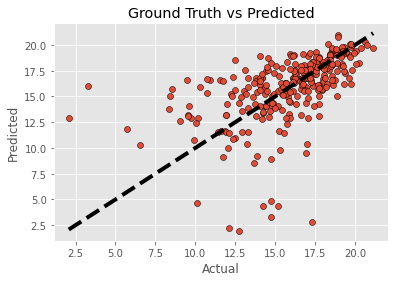

In [66]:
fig, ax = plt.subplots()
ax.scatter(y_valid, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

# Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
tree_size = [20,50,100,500,1000,1500,2000]

In [73]:
for size in tree_size:
    rf = RandomForestRegressor(n_estimators = size,oob_score = True,bootstrap = True,
                               random_state = 0)
    rf.fit(X_train, y_train)
    y_pred=rf.predict(X_valid)
    print('Tree size : {}'.format(size))
    print('R^2: {:.2f}'.format(rf.score(X_train, y_train))) 
    print('OOB Score: {:.2f}'.format(rf.oob_score_))
    print('R^2 Validation Score: {:.2f}'.format(rf.score(X_valid, y_valid)))
    # Mean Absolute error
    print('MAE: {}'.format(mean_absolute_error(y_valid, y_pred)))
    # Mean squared error
    print('MSE: {}'.format(mean_squared_error(y_valid, y_pred)))
    # Root mean squared error
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_valid, y_pred))))
    # Explained variance score: 1 is perfect prediction
    print('Test Variance score: {}'.format(r2_score(y_valid, y_pred)))
    print()

Tree size : 20
R^2: 0.92
OOB Score: 0.43
R^2 Validation Score: 0.46
MAE: 1.4963030594094284
MSE: 4.6736306237654075
RMSE: 2.16185814145272
Test Variance score: 0.4645083843276254

Tree size : 50
R^2: 0.92
OOB Score: 0.46
R^2 Validation Score: 0.48
MAE: 1.470125432532659
MSE: 4.499441639569741
RMSE: 2.121188732661415
Test Variance score: 0.4844664743197944

Tree size : 100
R^2: 0.93
OOB Score: 0.47
R^2 Validation Score: 0.49
MAE: 1.4618847773739267
MSE: 4.414601332038278
RMSE: 2.101095269624459
Test Variance score: 0.4941872411093533

Tree size : 500
R^2: 0.93
OOB Score: 0.49
R^2 Validation Score: 0.50
MAE: 1.4618914452717475
MSE: 4.391259442164096
RMSE: 2.0955332118971763
Test Variance score: 0.496861690018091

Tree size : 1000
R^2: 0.93
OOB Score: 0.49
R^2 Validation Score: 0.49
MAE: 1.4657459694433643
MSE: 4.409009927718748
RMSE: 2.099764255272184
Test Variance score: 0.49482788868593275

Tree size : 1500
R^2: 0.93
OOB Score: 0.49
R^2 Validation Score: 0.50
MAE: 1.4651849814249
MSE: 

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [ ]:
important_features = feature_importances.index[0:5]

In [ ]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
X_train.columns